In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score
import time
from sklearn.utils.class_weight import compute_class_weight
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/PGPDSE/Capstone/CSV Files/Diabetes_Preprocessed_Before_Feature_Selection.csv')
df.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,diabetesMed,readmitted,preceding_year_visits,number_changes,insulin_treatment
0,Caucasian,0,5,Not Available,Referral,1,41,0,1,Diabetes,Not Required,Not Required,1,None,None,-2,-2,-2,-2,-2,-2,-2,-2,0,0,0,0,no_med
1,Caucasian,0,15,Discharged to home,Emergency,3,59,0,18,"Endocrine, Nutritional, Metabolic, Immunity",Diabetes,"Endocrine, Nutritional, Metabolic, Immunity",9,None,None,-2,-2,-2,-2,-2,-2,-2,1,1,0,0,1,insulin_only
2,AfricanAmerican,0,25,Discharged to home,Emergency,2,11,5,13,"Pregnancy, Childbirth",Diabetes,External causes of injury,6,None,None,-2,-2,-2,0,-2,-2,-2,-2,1,0,3,0,other_meds
3,Caucasian,1,35,Discharged to home,Emergency,2,44,1,16,Infectious and Parasitic,Diabetes,Circulatory,7,None,None,-2,-2,-2,-2,-2,-2,-2,1,1,0,0,1,insulin_only
4,Caucasian,1,45,Discharged to home,Emergency,1,51,0,8,Neoplasms,Neoplasms,Diabetes,5,None,None,-2,-2,-2,0,-2,-2,-2,0,1,0,0,0,insulin_combo


In [ ]:
df.shape

(97070, 28)

In [ ]:
X = df.drop('readmitted', 1)
y = df['readmitted']
X_dum = pd.get_dummies(X, drop_first = True)
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size = 0.3, stratify = y, random_state = 0)

In [ ]:
num_cols = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
            'number_diagnoses', 'preceding_year_visits', 'number_changes']

In [ ]:
X_train.loc[:, num_cols].skew()

age                     -0.621101
time_in_hospital         1.145219
num_lab_procedures      -0.242766
num_procedures           1.316956
num_medications          1.336549
number_diagnoses        -0.890263
preceding_year_visits    5.562799
number_changes           1.428450
dtype: float64

In [ ]:
X_train.loc[:, num_cols].isna().sum()

age                      0
time_in_hospital         0
num_lab_procedures       0
num_procedures           0
num_medications          0
number_diagnoses         0
preceding_year_visits    0
number_changes           0
dtype: int64

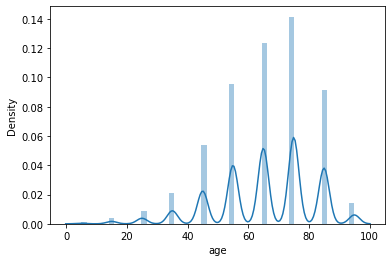

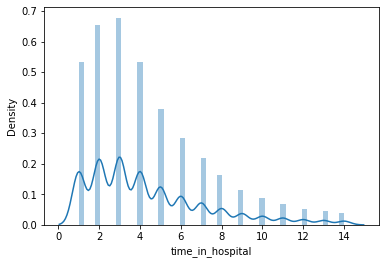

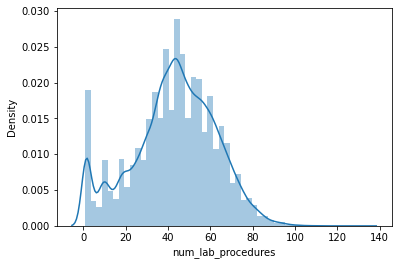

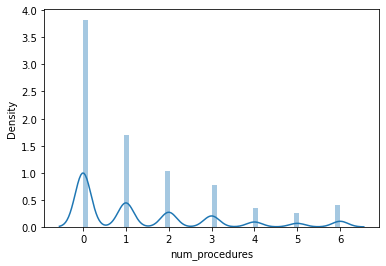

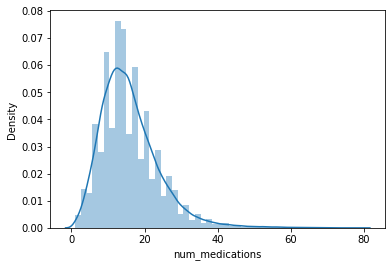

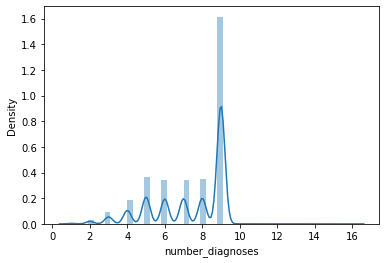

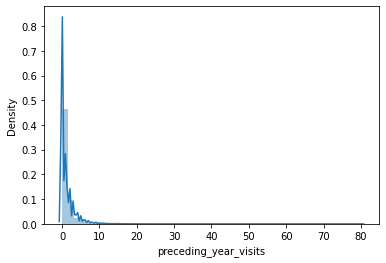

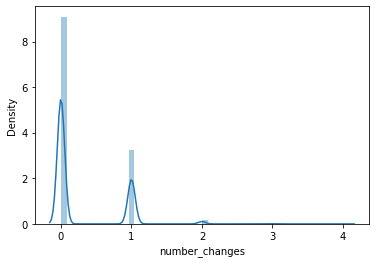

In [ ]:
for i in num_cols:
    sns.distplot(X_train[i])
    plt.show()

In [ ]:
num_cols = ['time_in_hospital', 'num_procedures', 'num_medications', 'preceding_year_visits', 'number_changes']

In [ ]:
skew_df = pd.DataFrame({"Skew Before" : df[num_cols].skew(), "Skew After" : np.sqrt(df[num_cols]).skew()})
skew_df

,Skew Before,Skew After
time_in_hospital,1.141139,0.476940
num_procedures,1.320396,0.406015
num_medications,1.331329,0.347681
preceding_year_visits,5.327782,1.164042
number_changes,1.425972,1.077153


In [ ]:
X_train[num_cols] = np.sqrt(X_train[num_cols])

In [ ]:
X_train.loc[:, num_cols].isna().sum()

time_in_hospital         0
num_procedures           0
num_medications          0
preceding_year_visits    0
number_changes           0
dtype: int64

In [ ]:
X_train.loc[:, num_cols].skew()

time_in_hospital         0.479532
num_procedures           0.405080
num_medications          0.348020
preceding_year_visits    1.153480
number_changes           1.075283
dtype: float64

In [ ]:
X_test[num_cols] = np.sqrt(X_test[num_cols])

In [ ]:
X_test.loc[:, num_cols].isna().sum()

time_in_hospital         0
num_procedures           0
num_medications          0
preceding_year_visits    0
number_changes           0
dtype: int64

In [ ]:
X_test.loc[:, num_cols].skew()

time_in_hospital         0.470813
num_procedures           0.408212
num_medications          0.346887
preceding_year_visits    1.188993
number_changes           1.081575
dtype: float64

In [ ]:
mm = MinMaxScaler()
X_train = pd.DataFrame(mm.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(mm.transform(X_test), columns = X_test.columns)
X_train.head()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,metformin,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,diabetesMed,preceding_year_visits,number_changes,race_Asian,race_Caucasian,race_Hispanic,race_Other,discharge_disposition_id_Discharged to home with home health service,discharge_disposition_id_Left AMA,discharge_disposition_id_Not Available,discharge_disposition_id_Still patient/referred to this institution,discharge_disposition_id_Transferred to another medical facility,admission_source_id_Not Available,admission_source_id_Referral,admission_source_id_Transferred from another health care facility,diag_1_Circulatory,diag_1_Congenital Anomalies,diag_1_Diabetes,diag_1_Digestive,"diag_1_Endocrine, Nutritional, Metabolic, Immunity",diag_1_External causes of injury,diag_1_Genitourinary,diag_1_Infectious and Parasitic,diag_1_Injury and Poisoning,diag_1_Mental Disorders,diag_1_Musculoskeletal System and Connective Tissue,diag_1_Neoplasms,diag_1_Nervous,diag_1_Other Symptoms,"diag_1_Pregnancy, Childbirth",diag_1_Respiratory,diag_1_Sense Organs,diag_1_Skin and Subcutaneous Tissue,diag_2_Circulatory,diag_2_Congenital Anomalies,diag_2_Diabetes,diag_2_Digestive,"diag_2_Endocrine, Nutritional, Metabolic, Immunity",diag_2_External causes of injury,diag_2_Genitourinary,diag_2_Infectious and Parasitic,diag_2_Injury and Poisoning,diag_2_Mental Disorders,diag_2_Musculoskeletal System and Connective Tissue,diag_2_Neoplasms,diag_2_Nervous,diag_2_Not Required,diag_2_Other Symptoms,"diag_2_Pregnancy, Childbirth",diag_2_Respiratory,diag_2_Sense Organs,diag_2_Skin and Subcutaneous Tissue,diag_3_Circulatory,diag_3_Congenital Anomalies,diag_3_Diabetes,diag_3_Digestive,"diag_3_Endocrine, Nutritional, Metabolic, Immunity",diag_3_External causes of injury,diag_3_Genitourinary,diag_3_Infectious and Parasitic,diag_3_Injury and Poisoning,diag_3_Mental Disorders,diag_3_Musculoskeletal System and Connective Tissue,diag_3_Neoplasms,diag_3_Nervous,diag_3_Not Required,diag_3_Other Symptoms,"diag_3_Pregnancy, Childbirth",diag_3_Respiratory,diag_3_Sense Organs,diag_3_Skin and Subcutaneous Tissue,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_treatment_insulin_only,insulin_treatment_no_med,insulin_treatment_other_meds
0,0.0,0.444444,0.528691,0.396947,0.408248,0.555915,0.466667,0.333333,0.0,0.666667,0.000000,0.0,0.0,0.0,0.333333,1.0,0.158114,0.707107,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.888889,0.151081,0.320611,0.000000,0.494280,0.400000,0.000000,0.0,0.000000,0.666667,0.0,0.0,0.0,0.666667,1.0,0.193649,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.666667,0.000000,0.000000,0.408248,0.395921,0.133333,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.111803,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.888889,0.450847,0.312977,0.000000,0.440169,0.533333,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.0,0.666667,1.0,0.000000,0.500000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### Linear Kernel

In [ ]:
model = svm.SVC(kernel = 'linear', C = 0.01)
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train)

Training Time: 172.17170214653015


AttributeError: ignored

In [ ]:
y_train_prob = model.decision_function(X_train)
start_time = time.time()
y_test_pred = model.predict(X_test)
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.decision_function(X_test)
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Prediction Time: 59.36860013008118
Train Accuracy Score: 0.885443494385495
Train Confusion Matrix:
 [[60165     0]
 [ 7784     0]] 

Train F1 Score: 0.0
Train Precision Score: 0.0
Train Recall Score: 0.0
Train ROC_AUC Score: 0.5086095532164929

Test Accuracy Score: 0.885443494385495
Test Confusion Matrix:
 [[25785     0]
 [ 3336     0]] 

Test F1 Score: 0.0
Test Precision Score: 0.0
Test Recall Score: 0.0
Test ROC_AUC Score: 0.5100932924399283


#### With Class Weight

In [ ]:
model = svm.SVC(kernel = 'linear', C = 0.01, class_weight = 'balanced', probability = True, random_state = 0)
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)[:, 1]
start_time = time.time()
y_test_pred = model.predict(X_test)
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.predict_proba(X_test)[:, 1]
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Training Time: 7658.7549550533295
Prediction Time: 242.23250699043274
Train Accuracy Score: 0.6488101370145256
Train Confusion Matrix:
 [[39791 20374]
 [ 3489  4295]] 

Train F1 Score: 0.26469047545681446
Train Precision Score: 0.174105152215331
Train Recall Score: 0.5517728674203495
Train ROC_AUC Score: 0.6465820131585724

Test Accuracy Score: 0.6496686240170324
Test Confusion Matrix:
 [[17072  8713]
 [ 1489  1847]] 

Test F1 Score: 0.26583189407023605
Test Precision Score: 0.17490530303030302
Test Recall Score: 0.5536570743405276
Test ROC_AUC Score: 0.6512498378260742
